Summary: 
- This notebook develops a time series cross-validation framework and uses the framework to compare different model performances on monthly CO2 volume. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from utils import ts_cross_validation, ts_split, set_outliers_as_null

# ignore future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
plt.style.use("bmh")

# Prep Data

In [2]:
df = pd.read_csv('data/co2.csv', header=0, names=['date', 'volume'])
df.head(5)

,date,volume
0,19580329,316.1
1,19580405,317.3
2,19580412,317.6
3,19580419,317.5
4,19580426,316.4


In [3]:
# change data type and set date as index
df.date = pd.to_datetime(df.date, format='%Y%m%d')
df.set_index(keys = 'date', drop = True, inplace = True)

<AxesSubplot:xlabel='date'>

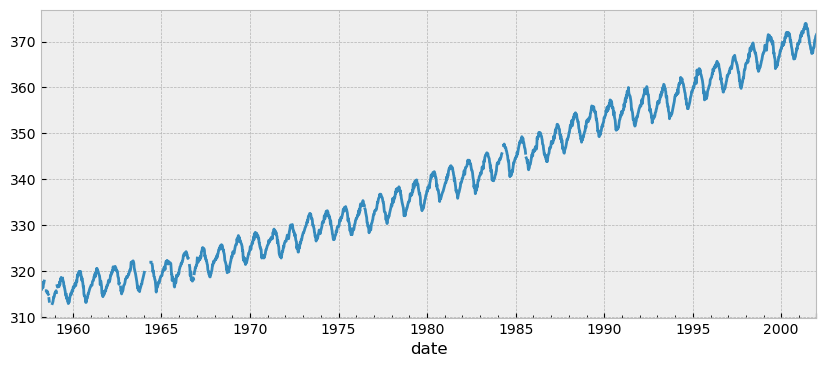

In [4]:
df.volume.plot(figsize = (10, 4))

Data have more many missing values at the beginning years

<AxesSubplot:xlabel='date'>

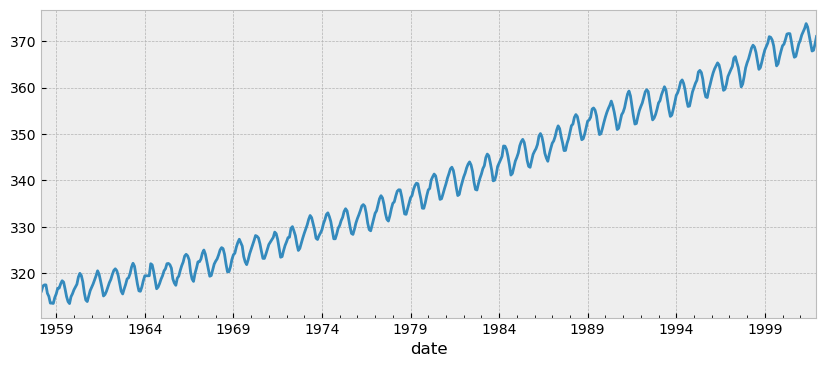

In [5]:
# get monthly mean
df = df.resample('MS').mean().ffill()
df.volume.plot(figsize = (10, 4))

# Seasonality Decomposition

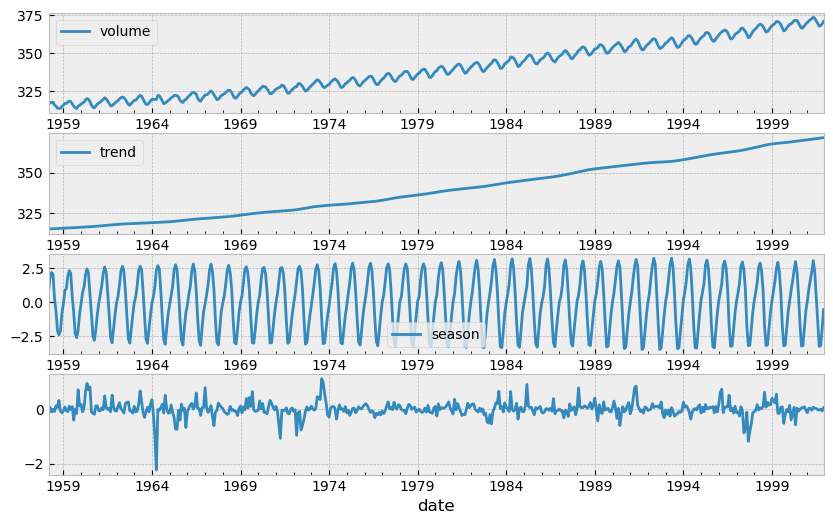

In [6]:
from statsmodels.tsa.seasonal import STL

# Robust Seasonality Decomposition identifying outliers
res = STL(df, robust=True).fit()

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(10, 6))
res.observed.plot(ax=ax1,)
res.trend.plot(ax=ax2,)
res.seasonal.plot(ax=ax3,)
res.resid.plot(ax=ax4,)
ax1.legend()
ax2.legend()
ax3.legend()
plt.show()

- magnitude of seasonality is changing with trend. `seasonality` is `multiplicative` not `additive`

# Train Test Split

In [7]:
df.shape

(526, 1)

In [8]:
# set training, test, and cross validation window
test_size = 30
initial = 345
horizon = 30
freq = 'MS' # monthly day and each date is the start of the month

In [9]:
# save the last X data points for testing
train = df[:-test_size]
test = df[-test_size:]
train_size = train.shape[0]
print (train.shape)
print (test.shape)

(496, 1)
(30, 1)


# Model Comparison with Cross Validation
from naive models to complex model

I defined two functions to implement [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) on time-series data
- `ts_cross_validation` implements cross-validation on the data with the model specified
    - However, model calling methods in different systems are not the same. For example, fitting and predicting methods between stats models and facebook prophet models are not the same. Embedding model calling inside the cross-validation functions seems rigid and needs more code maintenance in the future. 
    - Alternatively, I implement the second function `ts_split`
-  `ts_split`  focuses on splitting time series data and not train nor test the model. it's basically the first part of `ts_cross_validation`

## Naive Model
pred = last observation

In [10]:
# build naive model

from sklearn.base import RegressorMixin, BaseEstimator
class naive_forecast(RegressorMixin):
    def fit(self, X=None, y=None):
        # for a naive model, the prediction will always just be the last value
        # self.y_last = X[-1]
        
        self.y_last = X.loc[:, 'volume'].values[-1]

    def predict(self, n):
        return np.ones(n)*self.y_last

Train:0-345, size=346 
Test:346-375,  size=30
CV_error RMSE:4.84
Train:0-375, size=376 
Test:376-405,  size=30
CV_error RMSE:2.63
Train:0-405, size=406 
Test:406-435,  size=30
CV_error RMSE:3.36
Train:0-435, size=436 
Test:436-465,  size=30
CV_error RMSE:2.58
Train:0-465, size=466 
Test:466-495,  size=30
CV_error RMSE:4.65
cv rmse: [4.8, 2.6, 3.4, 2.6, 4.7] 

mean cv rmse: 3.614552114960324
std cv rmse: 1.0810041675658861


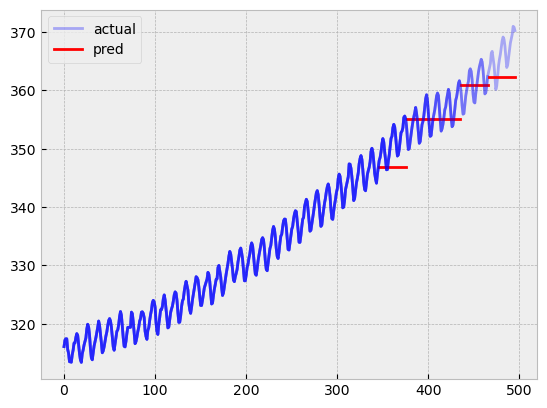

In [11]:
naive_m = naive_forecast()

naive_cv_error = ts_cross_validation(X= train, model=naive_m, initial=initial, horizon=horizon)
from statistics import mean, stdev, median

print('cv rmse:', [round(num, 1) for num in naive_cv_error], '\n')
print('mean cv rmse:', mean(naive_cv_error))
print('std cv rmse:', stdev(naive_cv_error))

## Moving Average

- pred = average of last 12 data points

In [12]:
# build MA model
from sklearn.base import RegressorMixin, BaseEstimator
class MA_model(BaseEstimator, RegressorMixin):
    def __init__(self, m=12):
        self.m = m
    
    def fit(self, X=None, y=None):
        # for a ma model, the prediction will be the average of last 3 values
        
        self.y_last_m = X.loc[:, 'volume'].values[-self.m:]
        #self.y_last_m = X[-self.m:]
        
        self.y_last_m_mean = np.mean(self.y_last_m)
        return self
    
    def predict(self, n):
        return np.ones(n)*self.y_last_m_mean      

Train:0-345, size=346 
Test:346-375,  size=30
CV_error RMSE:4.68
Train:0-375, size=376 
Test:376-405,  size=30
CV_error RMSE:3.12
Train:0-405, size=406 
Test:406-435,  size=30
CV_error RMSE:3.02
Train:0-435, size=436 
Test:436-465,  size=30
CV_error RMSE:4.02
Train:0-465, size=466 
Test:466-495,  size=30
CV_error RMSE:4.48
cv rmse: [4.7, 3.1, 3.0, 4.0, 4.5] 

mean cv rmse:3.86
std cv rmse:0.76


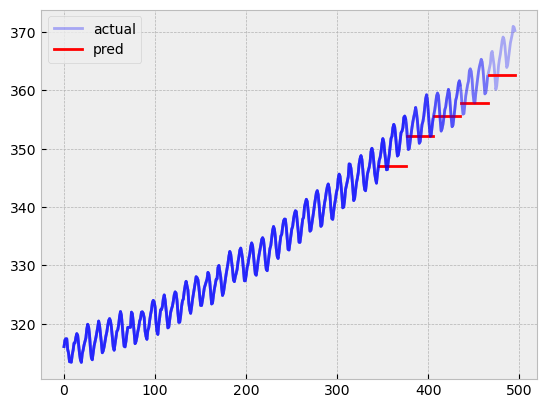

In [13]:
ma_model = MA_model(m=12)

ma_cv_error = ts_cross_validation(X= train, model=ma_model, initial=initial, horizon=horizon)

print('cv rmse:', [round(num, 1) for num in ma_cv_error], '\n')
print('mean cv rmse:{:.2f}'.format(mean(ma_cv_error)))
print('std cv rmse:{:.2f}'.format(stdev(ma_cv_error)))

## Moving Average (Tune m)

In [14]:
arr_m = np.arange(1, 15)
ma_error_mean = []
ma_error_std = []
for m in arr_m:
    ma_model = MA_model(m=m)
    ma_cv_error = ts_cross_validation(X= train, model=ma_model, initial=initial, horizon=horizon, plot_cv=False)
    ma_error_mean.append(mean(ma_cv_error))
    ma_error_std.append(stdev(ma_cv_error))

Train:0-345, size=346 
Test:346-375,  size=30
CV_error RMSE:4.84
Train:0-375, size=376 
Test:376-405,  size=30
CV_error RMSE:2.63
Train:0-405, size=406 
Test:406-435,  size=30
CV_error RMSE:3.36
Train:0-435, size=436 
Test:436-465,  size=30
CV_error RMSE:2.58
Train:0-465, size=466 
Test:466-495,  size=30
CV_error RMSE:4.65
Train:0-345, size=346 
Test:346-375,  size=30
CV_error RMSE:5.39
Train:0-375, size=376 
Test:376-405,  size=30
CV_error RMSE:2.73
Train:0-405, size=406 
Test:406-435,  size=30
CV_error RMSE:3.84
Train:0-435, size=436 
Test:436-465,  size=30
CV_error RMSE:2.61
Train:0-465, size=466 
Test:466-495,  size=30
CV_error RMSE:5.33
Train:0-345, size=346 
Test:346-375,  size=30
CV_error RMSE:6.03
Train:0-375, size=376 
Test:376-405,  size=30
CV_error RMSE:2.73
Train:0-405, size=406 
Test:406-435,  size=30
CV_error RMSE:4.41
Train:0-435, size=436 
Test:436-465,  size=30
CV_error RMSE:2.61
Train:0-465, size=466 
Test:466-495,  size=30
CV_error RMSE:5.88
Train:0-345, size=346 
Te

In [15]:
best_m = np.argmin(ma_error_mean)+1
print('best m = {} with min rmse'.format(best_m))

best m = 1 with min rmse


Train:0-345, size=346 
Test:346-375,  size=30
CV_error RMSE:4.84
Train:0-375, size=376 
Test:376-405,  size=30
CV_error RMSE:2.63
Train:0-405, size=406 
Test:406-435,  size=30
CV_error RMSE:3.36
Train:0-435, size=436 
Test:436-465,  size=30
CV_error RMSE:2.58
Train:0-465, size=466 
Test:466-495,  size=30
CV_error RMSE:4.65


cv rmse: [4.8, 2.6, 3.4, 2.6, 4.7] 

mean cv rmse:3.61
std cv rmse:1.08


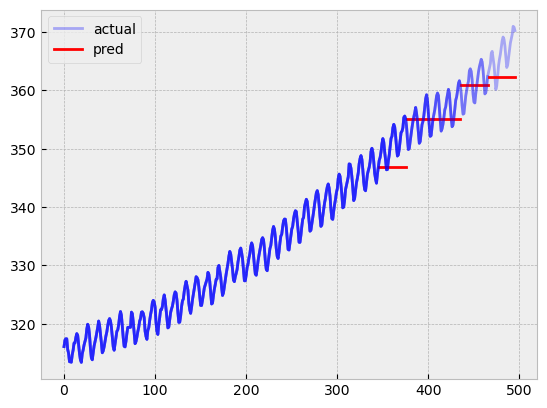

In [16]:
ma_model_best = MA_model(m=best_m)

ma_cv_error_best = ts_cross_validation(X= train, model=ma_model_best, initial=initial, horizon=horizon)

print ('\n')
print('cv rmse:', [round(num, 1) for num in ma_cv_error_best], '\n')
print('mean cv rmse:{:.2f}'.format(mean(ma_cv_error_best)))
print('std cv rmse:{:.2f}'.format(stdev(ma_cv_error_best)))

## Simple Exponential Smoothing
-`SimpleExpSmoothing` is a weighted average of previous observations with weights decaying exponentially as the observations get older.
- $\hat{y} = \alpha y_{t} + \alpha(1- \alpha) y_{t-1} + \alpha(1- \alpha)^2 y_{t-2} + ...$

In [17]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error

In [18]:
train_set = train.head(100)
train_set.index.freq

<MonthBegin>

Train:0-345, size=346 
Test:346-375,  size=30
First Predict:346.87 CV_error RMSE:4.84
Train:0-375, size=376 
Test:376-405,  size=30
First Predict:355.13 CV_error RMSE:2.63
Train:0-405, size=406 
Test:406-435,  size=30
First Predict:355.02 CV_error RMSE:3.36
Train:0-435, size=436 
Test:436-465,  size=30
First Predict:360.90 CV_error RMSE:2.58
Train:0-465, size=466 
Test:466-495,  size=30
First Predict:362.37 CV_error RMSE:4.65


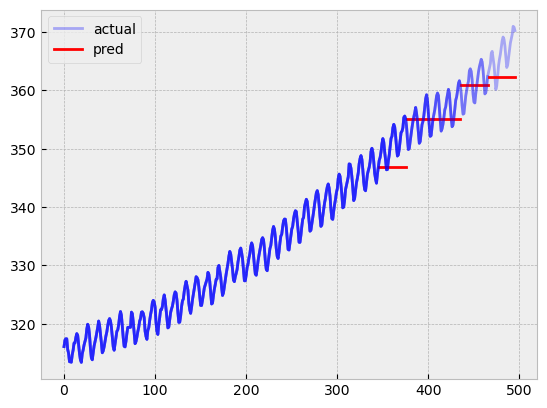

In [19]:
ses_cv_errors = []
for train_idx, test_idx in ts_split(train, initial=initial, horizon=horizon):
    X = train.reset_index()
    train_set = X.loc[train_idx, ].set_index('date')
    test_set = X.loc[test_idx, ].set_index('date')
    
    train_set, test_set = train_set.asfreq(freq), test_set.asfreq(freq)
    
    ses_fit = SimpleExpSmoothing(train_set).fit()
    pred = ses_fit.forecast(len(test_set))
    
    pred_error = np.sqrt(mean_squared_error(test_set.loc[:, 'volume'], pred))
    ses_cv_errors.append(pred_error)
    
    plot_x = np.concatenate((train_idx, test_idx))
    plot_y = np.concatenate((train_set.loc[:, 'volume'], test_set.loc[:, 'volume']))   
    plt.plot(plot_x, plot_y, color='b', alpha=0.3)
    
    # plot predicted values
    plt.plot(test_idx, pred, color='r')
    plt.legend(['actual', 'pred'])
    
    print(
            "First Predict:{:.2f}".format(pred[0]),
            "CV_error RMSE:{:.2f}".format(pred_error))

## Holt Winter's Model

- Holt Winter's model assumes there are trend and seasonality inside the time series data

Train:0-345, size=346 
Test:346-375,  size=30
First Predict:347.84 CV_error RMSE:1.58
Train:0-375, size=376 
Test:376-405,  size=30
First Predict:353.69 CV_error RMSE:0.45
Train:0-405, size=406 
Test:406-435,  size=30
First Predict:356.02 CV_error RMSE:0.66
Train:0-435, size=436 
Test:436-465,  size=30
First Predict:359.41 CV_error RMSE:1.26
Train:0-465, size=466 
Test:466-495,  size=30
First Predict:363.35 CV_error RMSE:1.32


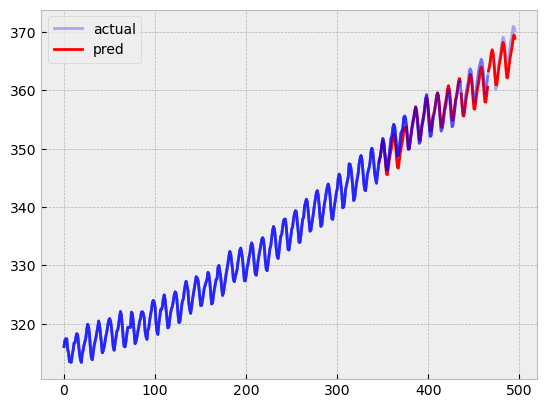

In [20]:
holt_winter_cv_errors = []
for train_idx, test_idx in ts_split(train, initial=initial, horizon=horizon):
    X = train.reset_index()
    train_set = X.loc[train_idx, ].set_index('date')
    test_set = X.loc[test_idx, ].set_index('date')
    
    # # Set the frequency
    train_set, test_set = train_set.asfreq(freq), test_set.asfreq(freq)
    
    holt_fit = ExponentialSmoothing(train_set,
                                    trend='add', seasonal = 'mul',
                                    initialization_method="estimated",
                                    # damped_trend=True
                                    ).fit(optimized=True)
    pred = holt_fit.forecast(len(test_set))
    
    pred_error = np.sqrt(mean_squared_error(test_set.loc[:, 'volume'], pred))
    holt_winter_cv_errors.append(pred_error)
    
    # plot training data
    plot_x = np.concatenate((train_idx, test_idx))
    plot_y = np.concatenate((train_set.loc[:, 'volume'], test_set.loc[:, 'volume']))   
    plt.plot(plot_x, plot_y, color='b', alpha=0.3)
    
    # plot predicted values
    plt.plot(test_idx, pred, color='r')
    plt.legend(['actual', 'pred'])
    
    print(
            "First Predict:{:.2f}".format(pred[0]),
            "CV_error RMSE:{:.2f}".format(pred_error))

In [21]:
# to check parameters
# holt_fit.params

## Default Facebook Prophet

- [Prophet](https://facebook.github.io/prophet/) is open source software released by Facebook’s Core Data Science team. 
- It forecasts time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data.

In [22]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [23]:
# format df to Prophet required format
prophet_train = train.reset_index().rename(columns = {'date':'ds', 'volume':'y'})
prophet_test = test.reset_index().rename(columns = {'date':'ds', 'volume':'y'})

Train:0-345, size=346 
Test:346-375,  size=30


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.03279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2187.36   0.000440386       12385.6           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2210.52   0.000484204       5130.47      0.8055      0.8055      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2219.95   0.000376786       2575.95           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2229.23   9.24915e-05       4041.51      0.5005      0.5005      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2233.08   0.000102335        1832.4           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[1.1359420120068968]
CV_error RMSE:1.14
Train:0-375, size=376 
Test:376-405,  size=30
Initial log joint probability = -2.05927
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2346.63    0.00168768       13915.5      0.8305      0.8305      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2368.9    0.00417327       11649.2       3.273      0.3273      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2376.78   7.06655e-05       861.045      0.4482      0.4482      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2378.31    3.3473e-05       747.379      0.6967      0.6967      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2387.08      0.001257        2714.7           1   

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[1.1359420120068968, 0.5772050491446621]
CV_error RMSE:0.58
Train:0-405, size=406 
Test:406-435,  size=30
Initial log joint probability = -2.04133
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2544.88    0.00783295       22184.9           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2559.09   0.000774869       14080.6      0.2009           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2570.32    0.00127644       6943.67           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2575.79   3.88447e-05       1693.17           1           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2578.22   3.72891e-05       73

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[1.1359420120068968, 0.5772050491446621, 1.8836478974532667]
CV_error RMSE:1.88
Train:0-435, size=436 
Test:436-465,  size=30
Initial log joint probability = -2.05674
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2661.28   0.000786031       31115.8      0.5794      0.5794      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2679.17   0.000482113       2675.02      0.9368      0.9368      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2686.2    0.00110553       6359.03           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2695.96   0.000203423       2439.64           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2700.32   

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[1.1359420120068968, 0.5772050491446621, 1.8836478974532667, 0.7012639794782153]
CV_error RMSE:0.70
Train:0-465, size=466 
Test:466-495,  size=30
Initial log joint probability = -2.04745
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2873.21   0.000783899       8818.33           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2904.95    0.00036313       3664.08           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2914.17   0.000652214       11518.1           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2920.79   0.000449631       7941.09      0.1806           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

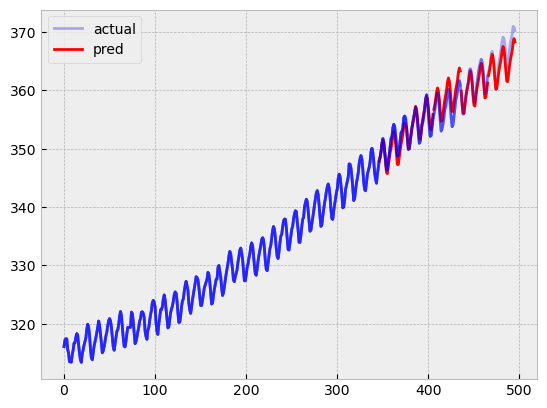

In [24]:
from mimetypes import init
from tabnanny import verbose

prophet_errors = []
for train_idx, test_idx in ts_split(prophet_train, initial=initial, horizon=horizon):
    
    train_set = prophet_train.loc[train_idx, ]
    test_set = prophet_train.loc[test_idx, ]
    
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(train_set)
   
    future = m.make_future_dataframe(periods=len(test_set), freq = 'MS') 
    pred = m.predict(future).iloc[-len(test_set):,]['yhat']

    pred_error = np.sqrt(mean_squared_error(test_set['y'], pred))
    prophet_errors.append(pred_error)
    print (prophet_errors)
    # plot training data
    plot_x = np.concatenate((train_idx, test_idx))
    plot_y = np.concatenate((train_set.loc[:, 'y'], test_set.loc[:, 'y']))   
    plt.plot(plot_x, plot_y, color='b', alpha=0.3)
    
    # plot predicted values
    plt.plot(test_idx, pred, color='r')
    plt.legend(['actual', 'pred'])
    
    print("CV_error RMSE:{:.2f}".format(pred_error))

## SARIMA

Seasonal [Autoregressive Integrated Moving Average](https://otexts.com/fpp2/arima.html). 
- SARIMA = Autoregressive Model + Moving Average Model
- Autoregressive Model: the future values to be forecasted is a linear combination of the past values
- Moving Average Model: the future values to be forecasted is a linear combination of the past forecast error. 

Train:0-345, size=346 
Test:346-375,  size=30
CV_error RMSE:1.25
Train:0-375, size=376 
Test:376-405,  size=30
CV_error RMSE:0.57
Train:0-405, size=406 
Test:406-435,  size=30


/Users/qiaowang/opt/anaconda3/envs/forecasting/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


CV_error RMSE:0.97
Train:0-435, size=436 
Test:436-465,  size=30
CV_error RMSE:1.45
Train:0-465, size=466 
Test:466-495,  size=30


/Users/qiaowang/opt/anaconda3/envs/forecasting/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


CV_error RMSE:1.01


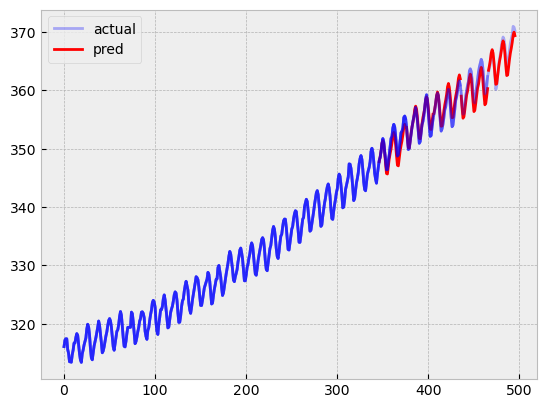

In [25]:
from sklearn import linear_model
sarima_errors = []

for train_idx, test_idx in ts_split(train, initial=initial, horizon=horizon):
    X = train.reset_index()
    train_set = X.loc[train_idx, ].set_index('date')
    test_set = X.loc[test_idx, ].set_index('date')

    train_set, test_set = train_set.asfreq(freq), test_set.asfreq(freq)

    mod = sm.tsa.statespace.SARIMAX(train_set,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity = False,
                                enforce_invertibility = False, freq='MS')
    tsresults = mod.fit(disp=0)
    pred = tsresults.predict(start=test_idx.min() , end=test_idx.max())
    
    pred_error = np.sqrt(mean_squared_error(test_set.loc[:, 'volume'], pred))
    sarima_errors.append(pred_error)
    
    # plot training data
    plot_x = np.concatenate((train_idx, test_idx))
    plot_y = np.concatenate((train_set.loc[:, 'volume'], test_set.loc[:, 'volume']))
    plt.plot(plot_x, plot_y, color='b', alpha=0.3)
    
    # plot predicted values
    plt.plot(test_idx, pred, color='r')
    plt.legend(['actual', 'pred'])
    
    print("CV_error RMSE:{:.2f}".format(pred_error))

## AutoArima CV

In [26]:
from pmdarima.arima import auto_arima

In [27]:
# tunning auto arima
arima_model = auto_arima(train, start_p=0, d=0, start_q=0, max_p= 3, max_d=0, max_q= 5, start_P=0, D=0, start_Q=0, max_P=7, max_D=0, max_Q=5, m=12,
                         seasonal=True, error_action='warn', trace=True, supress_warnings=True, stepwise=True
                        ,random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=4156.171, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=7186.591, Time=0.01 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=3493.915, Time=0.27 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1315.737, Time=0.57 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=591.300, Time=1.09 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=503.106, Time=4.08 sec
 ARIMA(1,0,1)(3,0,0)[12] intercept   : AIC=445.747, Time=13.9

/Users/qiaowang/opt/anaconda3/envs/forecasting/lib/python3.7/site-packages/pmdarima/arima/_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,0)(7,0,0)[12] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


 ARIMA(2,0,0)(7,0,0)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(3,0,1)(7,0,0)[12] intercept   : AIC=405.848, Time=133.25 sec
 ARIMA(2,0,2)(7,0,0)[12] intercept   : AIC=591.615, Time=25.53 sec
 ARIMA(1,0,0)(7,0,0)[12] intercept   : AIC=inf, Time=49.76 sec
 ARIMA(1,0,2)(7,0,0)[12] intercept   : AIC=389.550, Time=82.76 sec
 ARIMA(3,0,0)(7,0,0)[12] intercept   : AIC=inf, Time=88.58 sec
 ARIMA(3,0,2)(7,0,0)[12] intercept   : AIC=394.937, Time=95.15 sec
 ARIMA(2,0,1)(7,0,0)[12]             : AIC=417.156, Time=44.17 sec

Best model:  ARIMA(2,0,1)(7,0,0)[12] intercept
Total fit time: 1602.819 seconds


Train:0-345, size=346 
Test:346-375,  size=30
CV_error RMSE:1.62
Train:0-375, size=376 
Test:376-405,  size=30
CV_error RMSE:0.41
Train:0-405, size=406 
Test:406-435,  size=30
CV_error RMSE:0.51
Train:0-435, size=436 
Test:436-465,  size=30
CV_error RMSE:1.47
Train:0-465, size=466 
Test:466-495,  size=30
CV_error RMSE:1.46


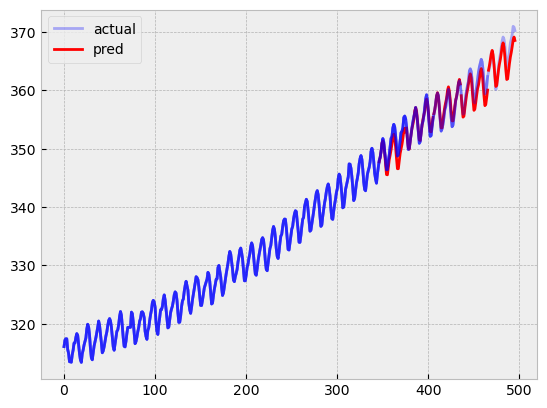

In [28]:
# auto arima cv

from sklearn import linear_model
auto_sarima_errors = []

for train_idx, test_idx in ts_split(train, initial=initial, horizon=horizon):
    X = train.reset_index()
    train_set = X.loc[train_idx, ].set_index('date')
    test_set = X.loc[test_idx, ].set_index('date')

    mod = arima_model
    tsresults = mod.fit(train_set)

    pred = tsresults.predict(n_periods=test_idx.shape[0], dynamic=True) 
    
    pred_error = np.sqrt(mean_squared_error(test_set.loc[:, 'volume'], pred))
    auto_sarima_errors.append(pred_error)
    
    # plot training data
    plot_x = np.concatenate((train_idx, test_idx))
    plot_y = np.concatenate((train_set.loc[:, 'volume'], test_set.loc[:, 'volume']))
    plt.plot(plot_x, plot_y, color='b', alpha=0.3)
    
    # plot predicted values
    plt.plot(test_idx, pred, color='r')
    plt.legend(['actual', 'pred'])
    
    print("CV_error RMSE:{:.2f}".format(pred_error))

# Performance Comparison

In [29]:
# put all cv errors in a dataframe
error_df = pd.DataFrame({'naive model':naive_cv_error, 'moving average(m=12)':ma_cv_error
                         , 'moving average best m':ma_cv_error_best
                         , 'exponential smoothing':ses_cv_errors
                         , "holt winter's model":holt_winter_cv_errors
                         , 'default prophet':prophet_errors
                         , 'sarima': sarima_errors
                         , 'auto_sarima': auto_sarima_errors})
error_df

,naive model,moving average(m=12),moving average best m,exponential smoothing,holt winter's model,default prophet,sarima,auto_sarima
0,4.842527,4.941303,4.842527,4.842527,1.581381,1.135942,1.249042,1.620430
1,2.633188,2.975744,2.633188,2.633189,0.446676,0.577205,0.569655,0.409123
2,3.360675,3.210600,3.360675,3.360675,0.659695,1.883648,0.971378,0.510243
3,2.584066,3.803141,2.584066,2.584066,1.257072,0.701264,1.446360,1.474710
4,4.652304,4.765424,4.652304,4.652304,1.316560,1.825971,1.012535,1.455713


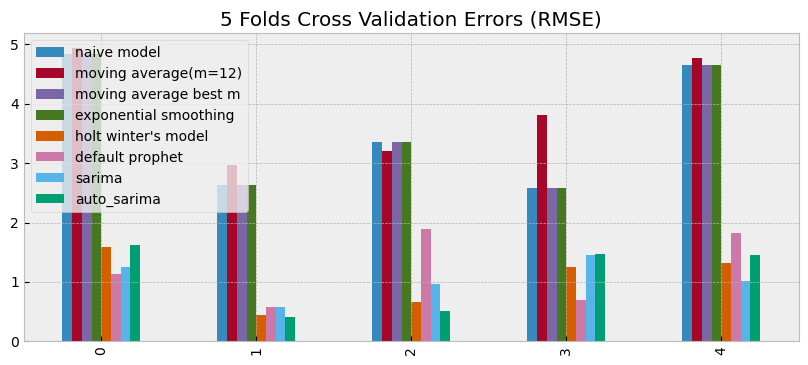

In [30]:
error_df.plot(kind='bar', title = '5 Folds Cross Validation Errors (RMSE)', figsize=(10, 4), )
plt.legend(loc='upper left')

<AxesSubplot:title={'center':'DE ATT 5-Fold CV RMSE STD'}>

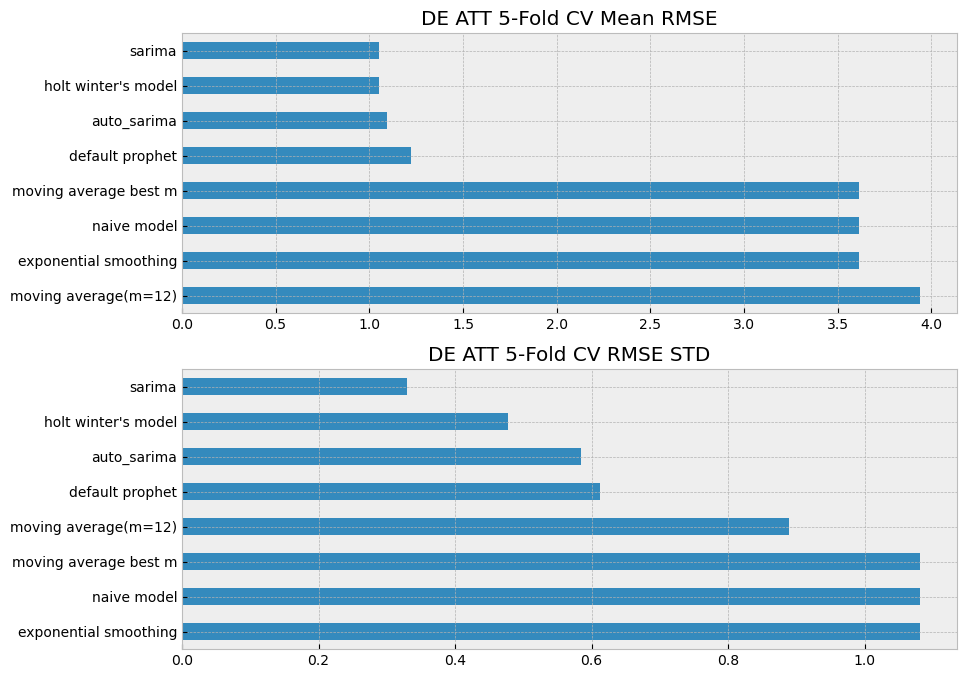

In [31]:
# error mean and std
error_df_mean = error_df.mean().sort_values(ascending=False)
error_df_std = error_df.std().sort_values(ascending=False)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
error_df_mean.plot(kind='barh', title = 'DE ATT 5-Fold CV Mean RMSE', ax=axes[0])
error_df_std.plot(kind='barh', title = 'DE ATT 5-Fold CV RMSE STD', ax=axes[1])

 - select SARIMA model for predicting because both of its mean and std of `rmse` are lower.
 - auto-sarima not necessarily outperform SARIMA after 40 mins parameters searching. It's a not a guaranteed winner. 